# Explain the Best Model
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import scored data
* Use Shapley Value to explain the model

# 1. Parameters

In [1]:
#Name
ModelName = 'titanic_segmentation_model'

#Setting the VarId and VarDate parameters
VarId = 'PassengerId'
VarDate = 'ReferenceDate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1


#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'NameTitle'
,'Sex']

#float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean']
selected_features = CAT + NUM

# 2. Import Libraries

In [2]:
# !pip -q install -r requirements.txt

In [3]:
try:
    import sys
    sys.path.append('/anaconda/envs/azureml_py38/lib/python3.8/site-packages')
except:
    pass

In [4]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import h2o
import seaborn as sns
import altair as alt

# 3. Importing Scored Data for Explain Modeling

In [5]:
datascored_df_full = pd.read_csv('./titanic/df_cluster.csv')

In [6]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    datascored_df = datascored_df_full.copy()
else:
    datascored_df = datascored_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del datascored_df_full

In [7]:
#List all dummies and normalized variables
normalized_and_dummy = []
for i in datascored_df.columns:
    if (i.startswith('dummy_')) or (i.startswith('normalized_')):
        normalized_and_dummy.append(i)
# normalized_and_dummy

In [8]:
#Numeric features must be float type
for col_name in (NUM + normalized_and_dummy):
    datascored_df[col_name] = datascored_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    datascored_df[col_name] = datascored_df[col_name].astype(str)

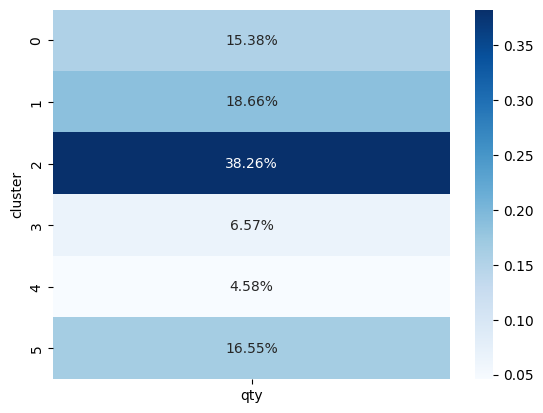

In [9]:
df_cluster_plot = datascored_df.reset_index().groupby(['cluster']).count()[['index']].rename(columns={'index': 'qty'})
# sns.heatmap(df_cluster_plot, annot=True, center=True,cmap='Blues', fmt='g')
# plt.show()
sns.heatmap(df_cluster_plot/np.sum(df_cluster_plot), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 4. Calculate Shapley Values using SHAP KernelExplainer for H20 models

#### The SHAP library calculates the Shaley Value of each variable used in the model and shows the individual impact of each variable on the predicted value for each record. To better understand how the SHAP library works, see the link https://github.com/slundberg/shap

## 4.1 For calculating the shapley value, we need to create a multiclass classification model using the clusters as the target featrure

In [10]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         5 mins 33 secs
H2O_cluster_timezone:       America/Sao_Paulo
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.3
H2O_cluster_version_age:    5 months and 13 days !!!
H2O_cluster_name:           H2O_from_python_giba_218r8a
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.421 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.10 final
--------------------------  -----------------------------

In [11]:
#Setting the model target variable name
VarTarget = 'cluster'

#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(datascored_df.loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 770
Validation: 82


In [12]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*2

#Define metrics to select the best model in AutoML
sort_metric = 'rmse'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
#                    distribution="multinomial",
#                    auc_type="MACRO_OVR",
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
21:52:36.878: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

█████████
21:52:57.875: GLM_1_AutoML_1_20221221_215235 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: Index 34 out of bounds for length 34

██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:02:20.245784



In [13]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id rmse mean_per_class_error logloss mse 
 
 
 GBM_3_AutoML_1_20221221_215235 0.290732 0.196345 0.410214 0.0845253 
 DRF_1_AutoML_1_20221221_215235 0.296835 0.21579 1.43328 0.0881112 
 GBM_2_AutoML_1_20221221_215235 0.297174 0.196345 0.434796 0.0883122 
 GBM_1_AutoML_1_20221221_215235 0.300537 0.168568 0.352078 0.0903227 
 GBM_4_AutoML_1_20221221_215235 0.304003 0.229679 0.438675 0.0924177 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20221221_215235 0.310022 0.176901 0.41483 0.0961138 
 StackedEnsemble_AllModels_1_AutoML_1_20221221_215235 0.310369 0.176901 0.432614 0.0963288 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20221221_215235 0.324608 0.31408 0.417459 0.10537 
 XGBoost_1_AutoML_1_20221221_215235 0.370404 0.388012 0.443677 0.137199 
 XGBoost_2_AutoML_1_20221221_215235 0.705495 0.457457 1.25427 0.497723

In [14]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_1_20221221_215235


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               50.0                     300.0             135791.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        2.0        8.0    7.936667         3.0        43.0    31.296667



ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0037306876126934918
RMSE: 0.06107935504483894
LogLoss: 0.027339538526208747
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


0      1      2     3     4      5  Error     Rate
0  119.0    0.0    0.0   0.0   0.0    0.0    0.0  0 / 119
1    0.0  139.0    0.0   0.0   0.0    0.0    0.0  0 / 139
2    0.0    0.0  297.0   0.0   0.0    0.0    0.0  0 / 297
3    0.0    0.0    0.0  51.0   0.0    0.0    0.0   0 / 51
4    0.0    0.0    0.0   0.0  36.0    0.0    0.0   0 / 36
5    0.0    0.0    0.0   0.0   0.0  128.0    0.0  0 / 128
6  119.0  139.0  297.0  51.0  36.0  128.0    0.0  0 / 770


Top-6 Hit Ratios: 


k  hit_ratio
0  1        1.0
1  2        1.0
2  3        1.0
3  4        1.0
4  5        1.0
5  6        1.0


ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.08452529333055483
RMSE: 0.2907323396709675
LogLoss: 0.41021418786200364
Mean Per-Class Error: 0.19634541703507222
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


0     1     2    3    4     5     Error    Rate
0   8.0   0.0   0.0  1.0  2.0   1.0  0.333333  4 / 12
1   0.0  20.0   0.0  0.0  0.0   0.0  0.000000  0 / 20
2   0.0   0.0  28.0  0.0  1.0   0.0  0.034483  1 / 29
3   1.0   0.0   0.0  3.0  0.0   1.0  0.400000   2 / 5
4   1.0   0.0   0.0  0.0  2.0   0.0  0.333333   1 / 3
5   0.0   0.0   0.0  1.0  0.0  12.0  0.076923  1 / 13
6  10.0  20.0  28.0  5.0  5.0  14.0  0.109756  9 / 82


Top-6 Hit Ratios: 


k  hit_ratio
0  1   0.890244
1  2   0.963415
2  3   0.987805
3  4   0.987805
4  5   1.000000
5  6   1.000000


ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.059770694481578436
RMSE: 0.24448045828159443
LogLoss: 0.20875454364032328
Mean Per-Class Error: 0.15537251571291985
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


0      1      2     3     4      5     Error      Rate
0  105.0    0.0    1.0   7.0   6.0    0.0  0.117647  14 / 119
1    0.0  138.0    0.0   0.0   1.0    0.0  0.007194   1 / 139
2    0.0    0.0  297.0   0.0   0.0    0.0  0.000000   0 / 297
3   12.0   10.0    0.0  27.0   0.0    2.0  0.470588   24 / 51
4    7.0    4.0    0.0   0.0  25.0    0.0  0.305556   11 / 36
5    0.0    3.0    0.0   1.0   0.0  124.0  0.031250   4 / 128
6  124.0  155.0  298.0  35.0  32.0  126.0  0.070130  54 / 770


Top-6 Hit Ratios: 


k  hit_ratio
0  1   0.929870
1  2   0.990909
2  3   0.997403
3  4   0.998701
4  5   1.000000
5  6   1.000000


Cross-Validation Metrics Summary: 


mean        sd  cv_1_valid  cv_2_valid  \
0                  accuracy   0.927273  0.031944    0.915584    0.876623   
1                       auc        NaN  0.000000         NaN         NaN   
2                       err   0.072727  0.031944    0.084416    0.123377   
3                 err_count  11.200000  4.919350   13.000000   19.000000   
4                   logloss   0.213888  0.052367    0.263639    0.276575   
5       max_per_class_error   0.490278  0.119234    0.437500    0.666667   
6   mean_per_class_accuracy   0.848754  0.066579    0.847040    0.746984   
7      mean_per_class_error   0.151246  0.066579    0.152960    0.253016   
8                       mse   0.060036  0.018559    0.075564    0.083049   
9                    pr_auc        NaN  0.000000         NaN         NaN   
10                       r2   0.976334  0.005453    0.972022    0.970102   
11                     rmse   0.242690  0.037710    0.274889    0.288182   

    cv_3_valid  cv_4_valid  cv_5_valid  
0     0.954545    0.941558    0.948052  
1          NaN         NaN         NaN  
2     0.045455    0.058442    0.051948  
3     7.000000    9.000000    8.000000  
4     0.173700    0.190782    0.164742  
5     0.375000    0.416667    0.555556  
6     0.912693    0.903889    0.833165  
7     0.087307    0.096111    0.166835  
8     0.043438    0.055803    0.042327  
9          NaN         NaN         NaN  
10    0.983165    0.976199    0.980184  
11    0.208419    0.236227    0.205734


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-12-21 21:54:03   2.203 sec              0.0       0.833333   
1     2022-12-21 21:54:03   2.298 sec              5.0       0.507245   
2     2022-12-21 21:54:03   2.357 sec             10.0       0.327873   
3     2022-12-21 21:54:03   2.404 sec             15.0       0.237744   
4     2022-12-21 21:54:03   2.455 sec             20.0       0.188466   
5     2022-12-21 21:54:03   2.508 sec             25.0       0.154005   
6     2022-12-21 21:54:04   2.565 sec             30.0       0.125216   
7     2022-12-21 21:54:04   2.621 sec             35.0       0.103411   
8     2022-12-21 21:54:04   2.666 sec             40.0       0.089036   
9     2022-12-21 21:54:04   2.724 sec             45.0       0.074859   
10    2022-12-21 21:54:04   2.771 sec             50.0       0.061079   

    training_logloss  training_classification_error  training_auc  \
0           1.791759                       0.775325           NaN   
1           0.713657                       0.046753           NaN   
2           0.380457                       0.037662           NaN   
3           0.232581                       0.025974           NaN   
4           0.154378                       0.019481           NaN   
5           0.106813                       0.015584           NaN   
6           0.076375                       0.009091           NaN   
7           0.056640                       0.006494           NaN   
8           0.044837                       0.001299           NaN   
9           0.035463                       0.000000           NaN   
10          0.027340                       0.000000           NaN   

    training_pr_auc  validation_rmse  validation_logloss  \
0               NaN         0.833333            1.791759   
1               NaN         0.549322            0.829219   
2               NaN         0.409383            0.545693   
3               NaN         0.351446            0.431388   
4               NaN         0.326445            0.388171   
5               NaN         0.311803            0.373784   
6               NaN         0.305118            0.369071   
7               NaN         0.297000            0.375823   
8               NaN         0.298480            0.398012   
9               NaN         0.294425            0.404174   
10              NaN         0.290732            0.410214   

    validation_classification_error  validation_auc  validation_pr_auc  
0                          0.804878             NaN                NaN  
1                          0.121951             NaN                NaN  
2                          0.109756             NaN                NaN  
3                          0.097561             NaN                NaN  
4                          0.109756             NaN                NaN  
5                          0.121951             NaN                NaN  
6                          0.121951             NaN                NaN  
7                          0.109756             NaN                NaN  
8                          0.109756             NaN                NaN  
9                          0.109756             NaN                NaN  
10                         0.109756             NaN                NaN


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0         Pclass           841.937195           1.000000    0.394034
1      NameTitle           361.124298           0.428921    0.169009
2           Fare           313.810303           0.372724    0.146866
3  cabine_prefix           265.257874           0.315057    0.124143
4            Sex           173.419662           0.205977    0.081162
5       Embarked            65.371597           0.077644    0.030594
6       Age_Mean            63.865295           0.075855    0.029889
7          SibSp            28.035725           0.033299    0.013121
8          Parch            23.892260           0.028378    0.011182

In [15]:
h2o_predict = best_AutoML.predict(data_hdf)
df_predict = h2o_predict.cbind(data_hdf).as_data_frame()
df_predict

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict        p0        p1        p2        p3        p4        p5  \
0          2  0.000092  0.000084  0.999579  0.000091  0.000082  0.000073   
1          3  0.084021  0.002491  0.001392  0.905430  0.003762  0.002904   
2          0  0.984138  0.000285  0.000270  0.012163  0.000458  0.002686   
3          2  0.000080  0.000094  0.999572  0.000114  0.000067  0.000073   
4          2  0.000090  0.000066  0.999588  0.000091  0.000078  0.000086   
..       ...       ...       ...       ...       ...       ...       ...   
847        1  0.000178  0.999203  0.000104  0.000195  0.000190  0.000129   
848        0  0.982061  0.000648  0.000347  0.014342  0.000571  0.002031   
849        5  0.000263  0.000807  0.000245  0.000660  0.000241  0.997784   
850        0  0.865227  0.002240  0.001465  0.002334  0.127047  0.001687   
851        2  0.000086  0.000062  0.999606  0.000083  0.000070  0.000092   

     Pclass Embarked cabine_prefix NameTitle     Sex     Fare  SibSp  Parch  \
0         3        S       missing        Mr    male   7.2500      1      0   
1         1        C             C       Mrs  female  71.2833      1      0   
2         1        S             C       Mrs  female  53.1000      1      0   
3         3        S       missing        Mr    male   8.0500      0      0   
4         3        Q       missing        Mr    male   8.4583      0      0   
..      ...      ...           ...       ...     ...      ...    ...    ...   
847       2        S       missing       LOW    male  13.0000      0      0   
848       1        S             B      Miss  female  30.0000      0      0   
849       3        S       missing      Miss  female  23.4500      1      2   
850       1        C             C        Mr    male  30.0000      0      0   
851       3        Q       missing        Mr    male   7.7500      0      0   

      Age_Mean  cluster  
0    22.000000        2  
1    38.000000        3  
2    35.000000        0  
3    35.000000        2  
4    29.699118        2  
..         ...      ...  
847  27.000000        1  
848  19.000000        0  
849  29.699118        5  
850  26.000000        0  
851  32.000000        2  

[852 rows x 17 columns]

In [16]:
#Funcao para calcular o valor de shapley
class H2oProbWrapper:
    def __init__(self, h2o_model, feature_names, NUM, CAT):
        self.h2o_model = h2o_model
        self.feature_names = feature_names
        self.NUM = NUM
        self.CAT = CAT
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1) 
        self.dataframe = pd.DataFrame(X, columns=self.feature_names)

        #Numeric features must be float type
        for col_name in self.NUM:
            self.dataframe[col_name] = self.dataframe[col_name].astype(float)

        #Categorical features must be string type and null values will be filled with "Missing"
        for col_name in self.CAT:        
            self.dataframe = self.dataframe.astype(str)
            self.dataframe = self.dataframe.fillna(value={col_name: 'Missing'})

        self.predictions = h2o.mojo_predict_pandas(self.dataframe.set_index(self.feature_names[0], inplace=False), mojo_zip_path=self.h2o_model, verbose=False)
        return self.predictions.drop(columns='predict').astype('float64').values

In [17]:
#The calculation of the Shapley Value for H20 models takes a while. So it will only be done for 20 records. Increase the sample to deepen your analysis
shap_sample = df_predict.loc[:,(selected_features)].sample(n=30, replace=False, random_state=1)
shap_sample = shap_sample.fillna(0)

In [18]:
path_model_mojo = best_AutoML.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
path_model_mojo

'/home/giba/pos/FIEP-Machine-Learning-e-Computacao-em-Nuvem/FIEP-Machine-Learning-e-Computacao-em-Nuvem/aula_02_titanic_kmeans/output_model/models/best/GBM_3_AutoML_1_20221221_215235.zip'

In [19]:
h2o_wrapper = H2oProbWrapper(path_model_mojo, selected_features, NUM, CAT)
h2o_explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, shap_sample)
h2o_shap_values = h2o_explainer.shap_values(shap_sample, nsamples="auto")

  0%|          | 0/30 [00:00<?, ?it/s]

## 4.1 Main SHAP Graphics

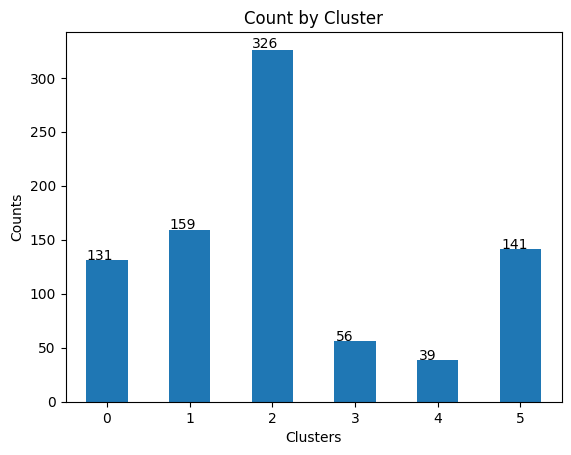

In [20]:
ax = df_predict.reset_index().groupby('cluster').agg('index').count().plot(kind='bar', stacked=False, ylabel='Counts', xlabel='Clusters',
             title='Count by Cluster', rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

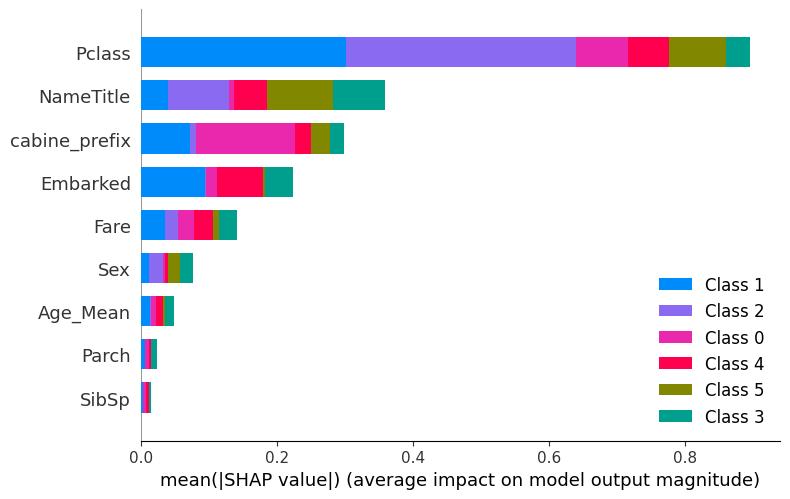

None

In [21]:
fig = shap.summary_plot(h2o_shap_values, shap_sample, plot_type="bar", show=True)
display(fig)

o Cluster é a maioria no numero do prefixo da cabine.

Cluster 1 e 2, praticamente dominam a classe. O cluster 1 é a maioria do embarque.

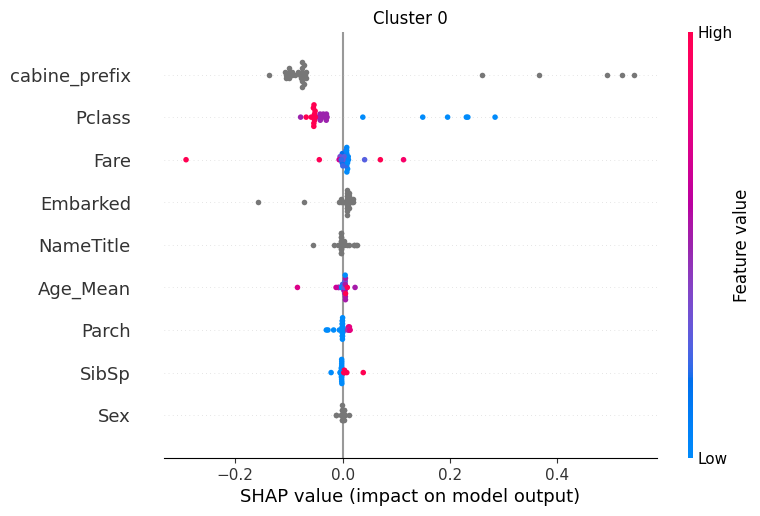

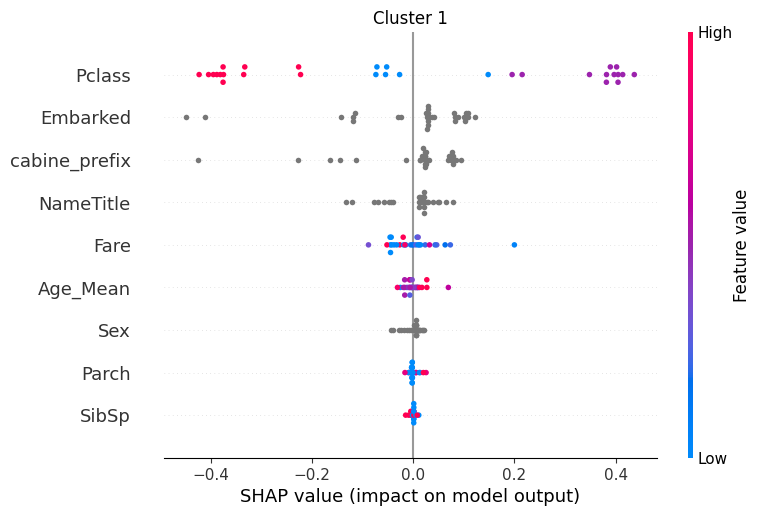

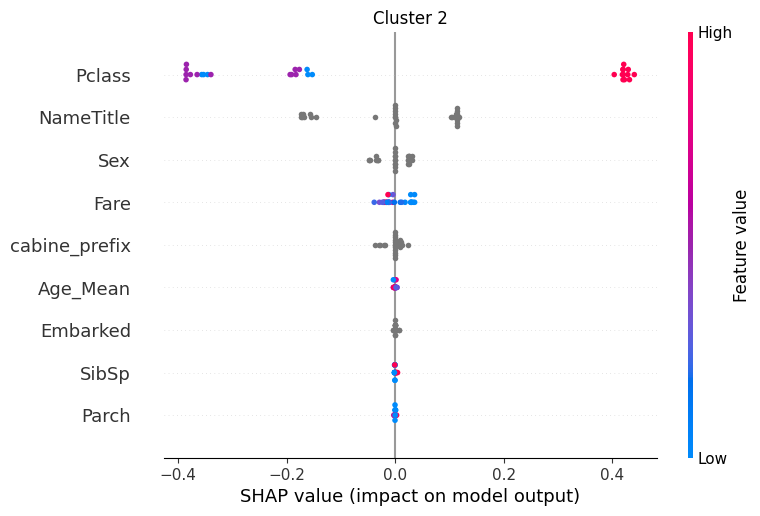

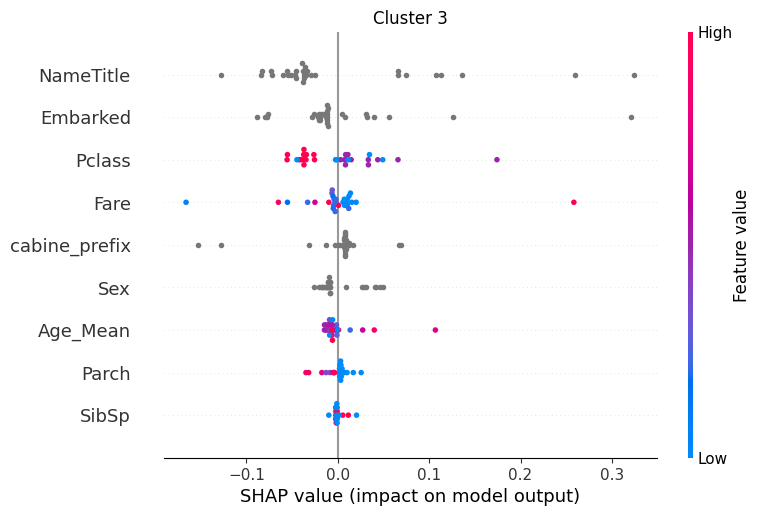

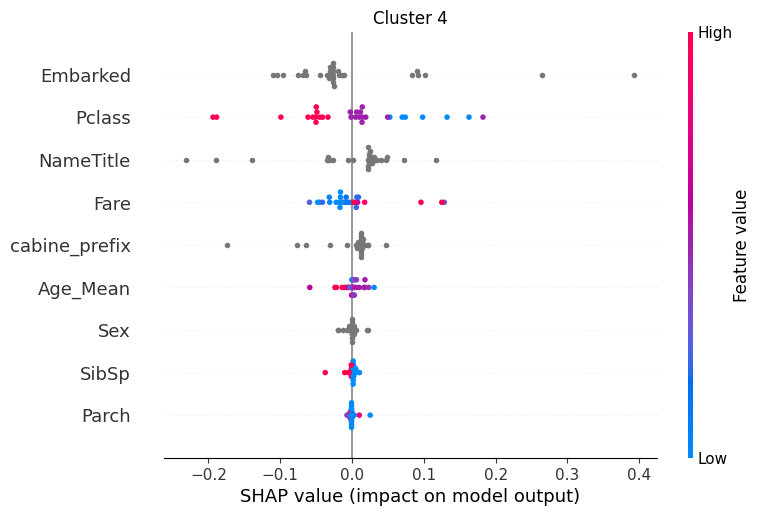

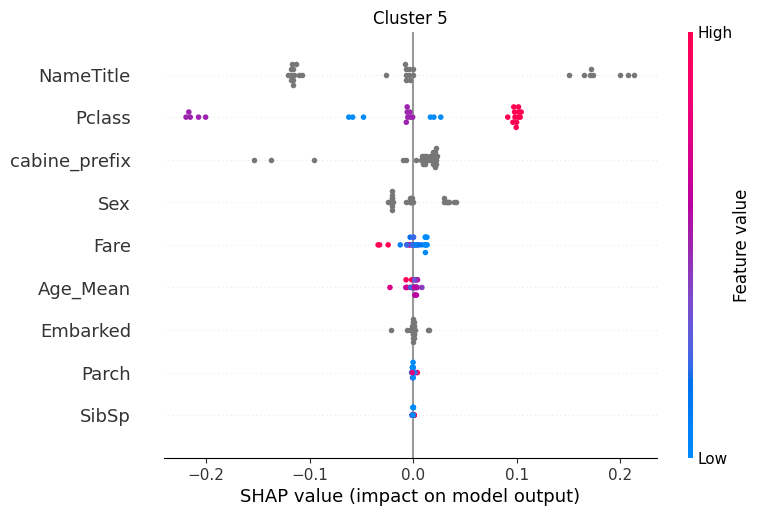

In [22]:
for cnr in range(len(df_predict['cluster'].unique())):
    shap.summary_plot(h2o_shap_values[cnr], shap_sample[selected_features], max_display=30, show=False)
    plt.title(f'Cluster {cnr}')
    plt.show()

Cluster 0, influenciou para ele a classe e o prefixo da cabine.
Cluster 1, tem mais gente da primeira classe
Cluster 2, seguiu dividindo por classe
Cluster 3 , todos os argumentos influenciaram, mas o nome principalmente
Cluster 4 , embarque e a classe
Cluster 5, principalmente a classe, porem com todas elas.

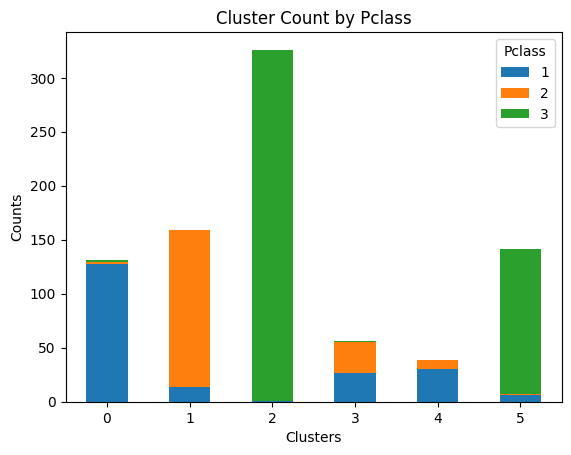

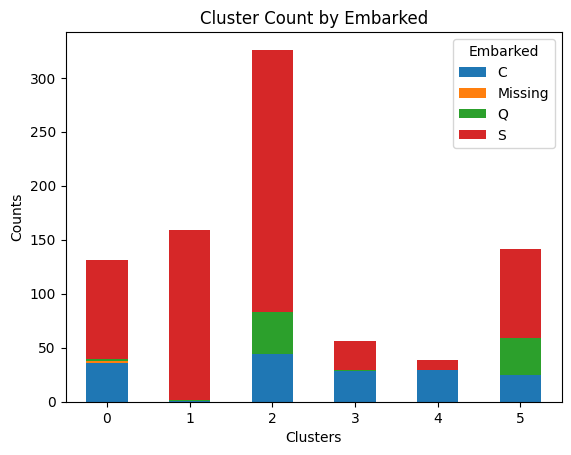

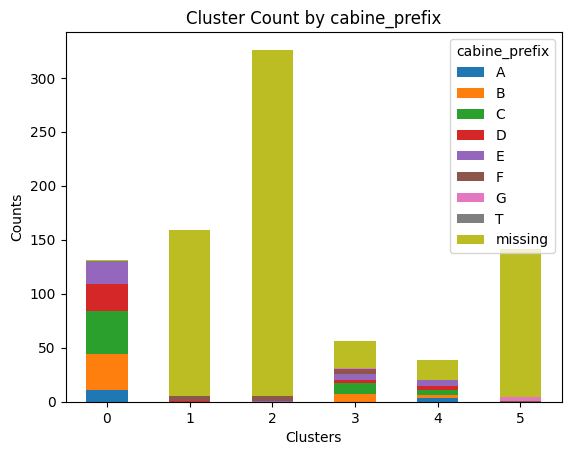

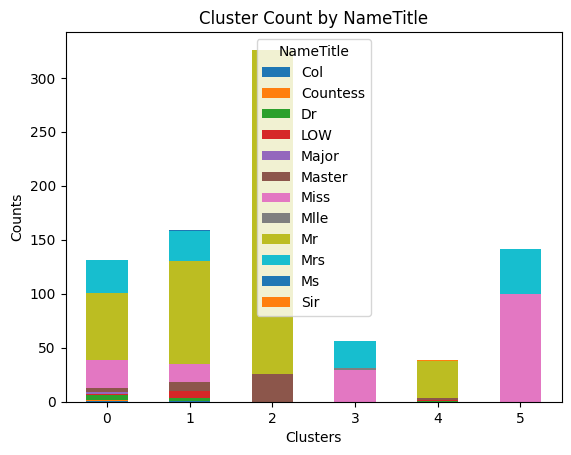

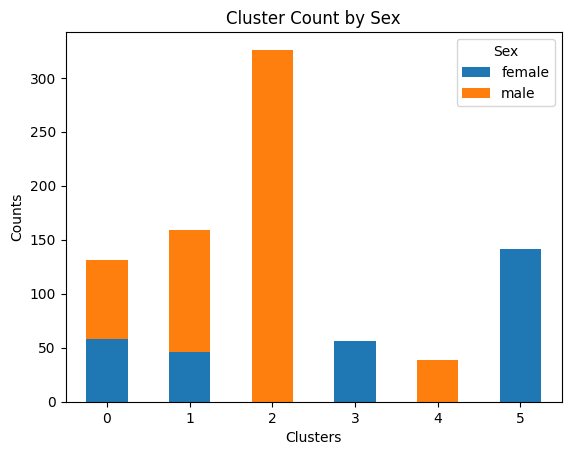

In [23]:
for i in CAT:
    # create a pivot table
    dfp = df_predict[[i,'cluster']].pivot_table(index='cluster', columns=[i], aggfunc=len)

    # plot the dataframe
    dfp.plot(kind='bar', stacked=True, ylabel='Counts', xlabel='Clusters',
             title=f'Cluster Count by {i}', rot=0)

Cluster 0, formada por classe alta que embarcaram entre o S e o O, formada por homem mulher e caisais.

Cluster 1 – maioria de classe média, embarcaram quase todos no setor S, maioria homem.


Cluster 2 -  formado por classe C, totalitário de homens. 

Cluster 3- Exclusivo feminino, quase sem classe C

Cluster 4 – classe entre 1 e 2, totalitários de homens.
 
Cluster 5- somente mulheres da classe C.

In [24]:
def plot_comparison(data, feature):
    print(feature)
    cluster_qty = len(data['cluster'].unique())

    fig, ax = plt.subplots(cluster_qty, 1, sharex=True, constrained_layout=True, figsize=(15,cluster_qty))
    fig.suptitle(f'Feature {feature}', fontsize=16)

    for j in range(cluster_qty):
        sns.violinplot(x=data.query(f'cluster == {j}')[i].rename(""), ax=ax[j])
        ax[j].set_title('Cluster ' + str(j))
    plt.show()
    plt.close()

Fare


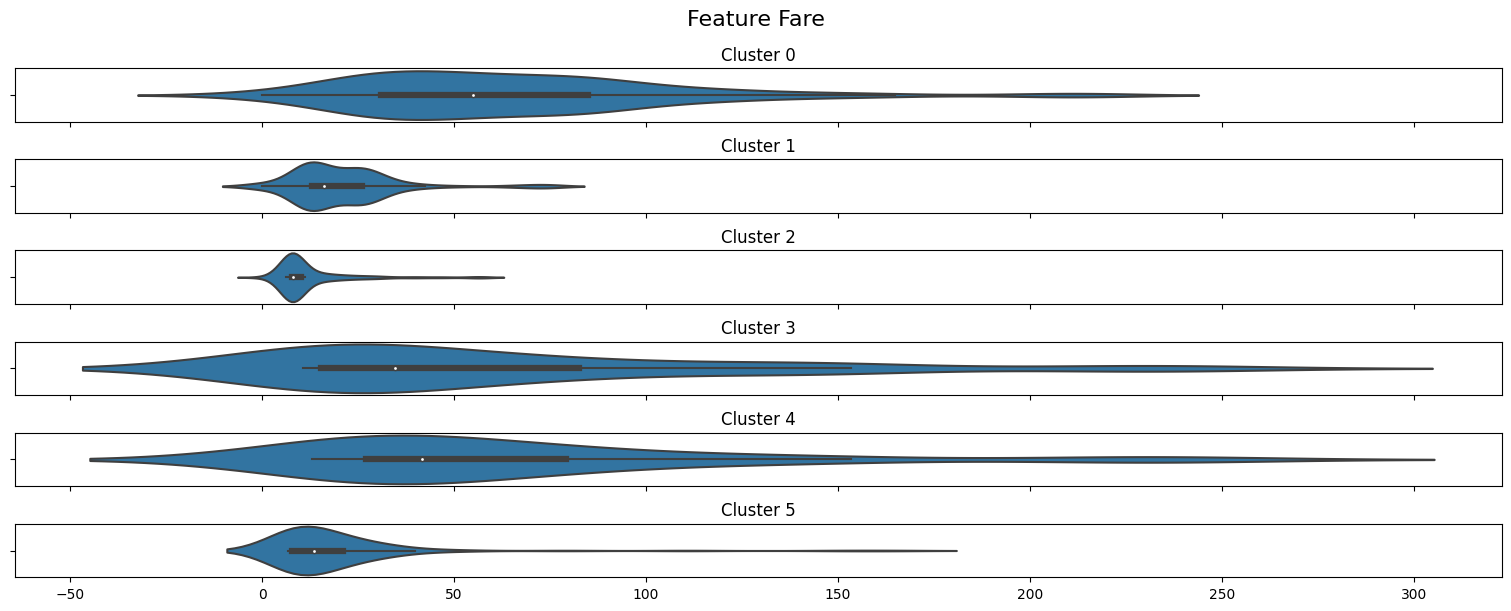

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

SibSp


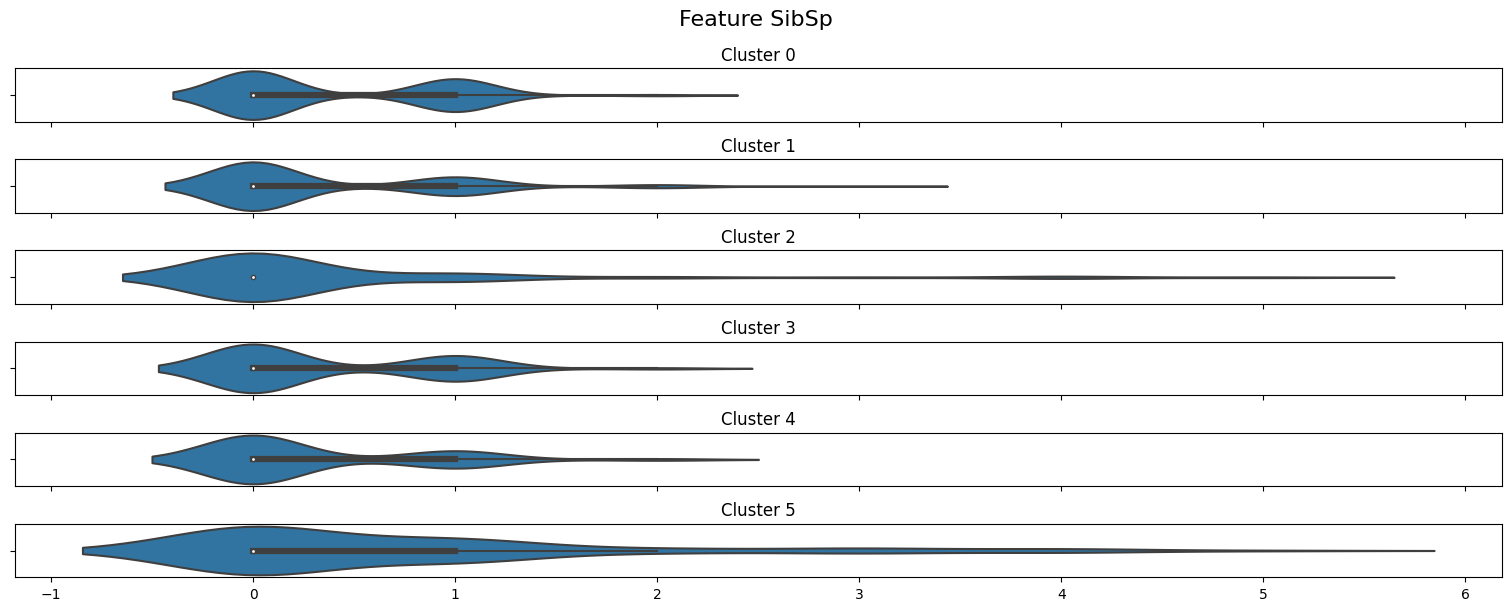

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

Parch


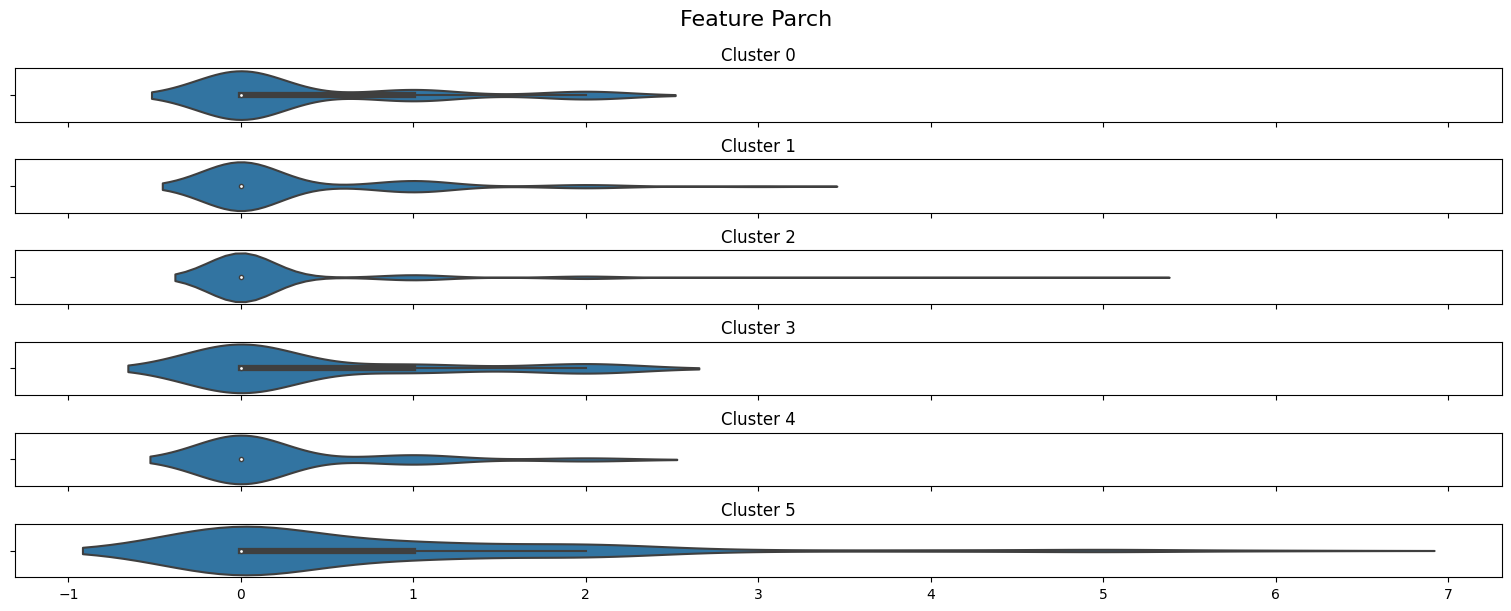

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

Age_Mean


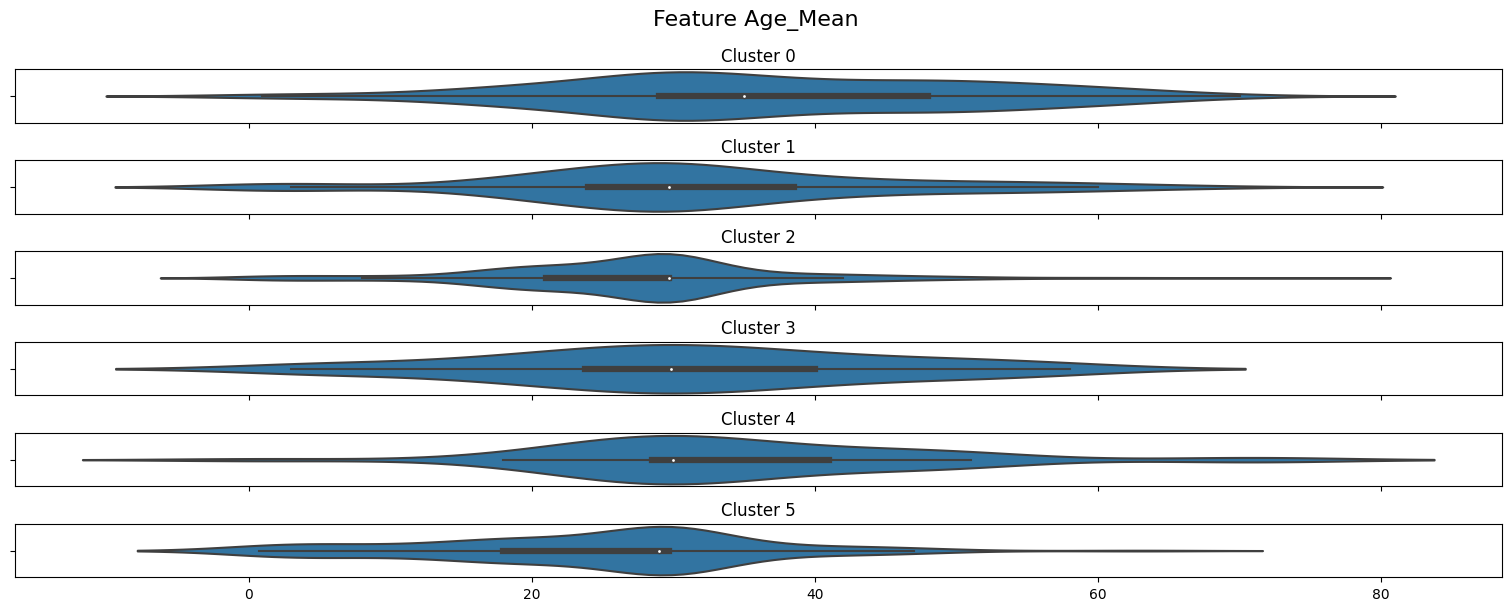

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

In [25]:
for i in NUM:
    plot_comparison(df_predict[[i]+['cluster']], i)
    
    cluster_qty = len(df_predict['cluster'].unique())
    for j in NUM:
        if i!=j:
            display(alt.Chart(df_predict).mark_point().encode(x=str(j)+':Q', y=str(i)+':Q', color='cluster:N', tooltip=selected_features).interactive().properties(
                    width=180,
                    height=180
                    ).facet(
                    facet='cluster:N',
                    columns=cluster_qty
                    ).resolve_axis(
                    x='independent',
                    y='independent',
                    ))